# SCROLL DOWN TO BOTTOM

## Initial setup
This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
This notebook present a second stage on a SA and UA. It is a variance-based approach using the SOBOL. 
For this, The EMA workbench is used with SALib SOBOL sampler and SALib analyse methods.
    

In [1]:

'''
by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

'''
import sys
import os

# sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append('/home/XXX/Repositories/gr4sp/experiments/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import glob
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import glob

includePlots = True
plt.rcParams.update({'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10, 'font.size': 10, 'legend.fontsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8})

## SOBOL visualization functions
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 25

In [3]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, uncertainties, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15 #25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties,
                      columns=uncertainties)
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = uncertainties
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc='lower center', bbox_to_anchor=(1, 1), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [4]:
from ema_workbench import load_results

#results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL2020ABY-Dec-23.tar.gz')
# results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL2021-Feb-03.tar.gz')
results = load_results('../simulationData/SOBOLFULL.tar.gz')
# results = load_results('../simulationData/gr4sp_SOBOL2021-Feb-03.tar.gz')

In [4]:
experiments, outcomes = results

In [5]:
outcomes.keys()

dict_keys(['TIMEYear', 'consumptionYear', 'tariffsYear', 'primaryWholesalePriceYear', 'GHGYear', 'numConsumersYear', 'primarySpotProductionYear', 'secondarySpotProductionYear', 'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 'solarProductionYear', 'BatteryProductionYear', 'numActorsYear', 'primaryUnmetDemandMwh', 'primaryUnmetDemandHours', 'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 'secondaryUnmetDemandMwh', 'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays', 'secondaryMaxUnmetDemandMwhPerHour', 'seedExperimentCsv'])

In [7]:
experiments, outcomes = results
outcomes['PrimarySpot-WholesalePriceYear'] = outcomes['primaryWholesalePriceYear']
# outcomes['PrimarySpot-WholesalePriceYear'] = outcomes['wholesalePriceYear']

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

## Uncertainties/levers

The outcomes are shown per year. Though another analysis can be done for monthly outcomes. 

In [10]:
# outcomes_to_show = ['consumptionYear', 'tariffsYear', 'PrimarySpot-WholesalePriceYear', 'GHGYear', 
#                     'primarySpotProductionYear', 'secondarySpotProductionYear', 
#                     'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
#                     'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
#                     'solarProductionYear', 'primaryUnmetDemandMwh', 
#                     'primaryUnmetDemandHours', 'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 
#                     'secondaryUnmetDemandMwh', 'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays', 
#                     'secondaryMaxUnmetDemandMwhPerHour']



outcomes_to_show = ['tariffsYear', 'primaryWholesalePriceYear', 'GHGYear', 
                    'renewableContributionYear', 'primaryUnmetDemandDays']

# outcomes_to_show = ['tariffsYear', 'wholesalePriceYear', 'GHGYear', 
#                     'renewableContributionYear', 'primaryUnmetDemandDays']


#outcomes_to_show = ['PrimarySpot-WholesalePriceYear']


# 23 levers/uncertainties selected after EET (last test July 2020)
# 25 uncertainties selected aftet EET including change on domestic demand and unmet demand output (August 2020)
# 26 uncertainties selected after EET for changes afterBaseYear(Dec 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 2019
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

In [11]:
# for n in uncertainties:
#     var = experiments[n]
#     val = np.unique(var)
#     print("{}: {}".format(n,val))

## SOBOL
To obtain the SALib results for each input for the sobol sensitivity indices (S1, S2, and ST)

## NEED TO ASSERT ALL UNCERTAINTIES

In [12]:
from gr4spModelSOBOL import getModelAFterBaseYear

from gr4spReduceFullModel import getModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

# model = getModelAFterBaseYear()

model = getModel()


uncertaintyCategories = determine_parameters(model, 'uncertainties', union=False) 
problem = get_SALib_problem(uncertaintyCategories)

In [13]:
problem

{'num_vars': 31,
 'names': ['annualCpi',
  'annualInflation',
  'consumption',
  'domesticConsumptionPercentage',
  'energyEfficiency',
  'generationRolloutPeriod',
  'generatorRetirement',
  'importPriceFactor',
  'includePublicallyAnnouncedGen',
  'learningCurve',
  'nameplateCapacityChangeBattery',
  'nameplateCapacityChangeBrownCoal',
  'nameplateCapacityChangeCcgt',
  'nameplateCapacityChangeOcgt',
  'nameplateCapacityChangeSolar',
  'nameplateCapacityChangeWater',
  'nameplateCapacityChangeWind',
  'nonScheduleGenSpotMarket',
  'nonScheduleMinCapMarketGen',
  'priceChangePercentageBattery',
  'priceChangePercentageBrownCoal',
  'priceChangePercentageCcgt',
  'priceChangePercentageOcgt',
  'priceChangePercentageSolar',
  'priceChangePercentageWater',
  'priceChangePercentageWind',
  'rooftopPV',
  'scheduleMinCapMarketGen',
  'solarUptake',
  'technologicalImprovement',
  'wholesaleTariffContribution'],
 'bounds': [(1, 5),
  (1, 5),
  (0, 4),
  (20, 50),
  (0, 3),
  (1, 10),
  (-5

In [14]:
from tqdm.notebook import tqdm
def isclose(a, b, rel_tol=1e-09):
    return abs(a-b) <= rel_tol 

from SALib.analyze import sobol

sobol_stats_years_ooi = {}
s1_years_ooi = {}
s1_conf_years_ooi = {}
st_years_ooi = {}
st_conf_years_ooi = {}
s2_years_ooi = {}
s2_conf_years_ooi = {}
num_uncertainties = len(uncertainties)
print(num_uncertainties)
for ooi in tqdm(outcomes_to_show):
    sobol_stats_years = pd.DataFrame([],columns=uncertainties)
    s1_years = pd.DataFrame([],columns=uncertainties)
    s1_conf_years = pd.DataFrame([],columns=uncertainties)
    st_years = pd.DataFrame([],columns=uncertainties)
    st_conf_years = pd.DataFrame([],columns=uncertainties)
    s2_years = {}
    s2_conf_years = {}
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_uncertainties = p to do the analysis with p levels
        stdY = dataY.std()
        print("{} - std: {}".format(startYear+t, stdY ) )

        if isclose(stdY, 0.0, rel_tol=1e-9):
            sobol_indices = {}
            sobol_indices['ST'] = np.zeros( num_uncertainties )
            sobol_indices['ST_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S1'] = np.zeros( num_uncertainties )
            sobol_indices['S1_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S2'] = np.zeros( (num_uncertainties, num_uncertainties) )
            sobol_indices['S2_conf'] = np.zeros( (num_uncertainties, num_uncertainties) )
        else:
            sobol_indices = sobol.analyze(problem, dataY)
        
        sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
        
        sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)
        sobol_stats.sort_values(by='ST', ascending=False)
        s1 = pd.DataFrame([sobol_indices['S1']], columns=uncertainties)
        s1_conf = pd.DataFrame([sobol_indices['S1_conf']], columns=uncertainties)
        st = pd.DataFrame([sobol_indices['ST']], columns=uncertainties)
        st_conf = pd.DataFrame([sobol_indices['ST_conf']], columns=uncertainties)
        s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties, columns=uncertainties)
        s2_conf = pd.DataFrame(sobol_indices['S2_conf'], columns=uncertainties)
        
        sobol_stats_years = sobol_stats_years.append(sobol_stats, sort=False)
        s1_years = s1_years.append(s1, sort=False)
        s1_conf_years = s1_conf_years.append(s1_conf, sort=False)
        st_years = st_years.append(st, sort=False)
        st_conf_years = st_conf_years.append(st_conf, sort=False)
        s2_years[startYear] = s2
        s2_conf_years[startYear+t] = s2_conf
    
    s1_years = s1_years.set_index(time)        
    s1_conf_years = s1_conf_years.set_index(time)
    st_years = st_years.set_index(time)
    st_conf_years = st_conf_years.set_index(time)

    
    sobol_stats_years_ooi[ooi] = sobol_stats_years
    s1_years_ooi[ooi] = s1_years
    s1_conf_years_ooi[ooi] = s1_conf_years
    st_years_ooi[ooi] = st_years
    st_conf_years_ooi[ooi] = st_conf_years
    s2_years_ooi[ooi] = s2_years
    s2_conf_years_ooi[ooi] = s2_conf_years
    print(ooi)
    #break
    


31


  0%|          | 0/5 [00:00<?, ?it/s]

2040 - std: 0.09555820062664935
2041 - std: 20.229049173786155
2042 - std: 10.63777915902624
2043 - std: 8.946117818681486
2044 - std: 6.836608734025022
2045 - std: 6.039637919681654
2046 - std: 5.38737954994247
2047 - std: 5.764943816942231
2048 - std: 6.449904578996413
2049 - std: 9.388088847096569
2050 - std: 12.72040785430571
2051 - std: 15.482743686291105
2052 - std: 20.134745813119313
2053 - std: 25.667865912663768
2054 - std: 31.043789347111655
2055 - std: 24.5732959143716
2056 - std: 28.08640345128782
2057 - std: 30.937038399299183
2058 - std: 34.072563772803704
2059 - std: 37.972772390768476
2060 - std: 54.81603757430439
2061 - std: 46.00395701242991
2062 - std: 43.064567708590005
2063 - std: 44.19178380649181
2064 - std: 48.327128041789095
2065 - std: 63.453788875748
2066 - std: 73.61289055128945
2067 - std: 85.12972218324785
2068 - std: 78.93273529782152
2069 - std: 78.34837910654866
2070 - std: 73.69396335690928
2071 - std: 72.66772876632199
tariffsYear
2040 - std: 82.14077

### Median and Max S1,ST,S2 and confidence intervals for all years in data frame

In [15]:
s1_median_ooi = {}
s1_max_val_ooi = {}
s1_max_val_year_ooi = {}
s1_conf_median_ooi = {}
s1_conf_max_val_ooi = {}
s2_median_ooi = {}
s2_max_val_ooi = {}
s2_conf_median_ooi = {}
s2_conf_max_val_ooi = {}
st_median_ooi = {}
st_max_val_ooi = {}
st_max_val_year_ooi = {}
st_conf_median_ooi = {}
st_conf_max_val_ooi = {}

ntime = len(time)
for ooi in tqdm(outcomes_to_show):
    
    s1_median_ooi[ooi] = s1_years_ooi[ooi].median()    
    s1_max_val_ooi[ooi] = s1_years_ooi[ooi].max()
    s1_max_val_year_ooi[ooi] = s1_years_ooi[ooi].idxmax()
    s1_conf_median_ooi[ooi] = s1_conf_years_ooi[ooi].median()    
    s1_conf_max_val_ooi[ooi] = s1_conf_years_ooi[ooi].max()
    st_median_ooi[ooi] = st_years_ooi[ooi].median()
    st_max_val_ooi[ooi] = st_years_ooi[ooi].max()
    st_max_val_year_ooi[ooi] = st_years_ooi[ooi].idxmax()
    st_conf_median_ooi[ooi] = st_conf_years_ooi[ooi].median()
    st_conf_max_val_ooi[ooi] = st_conf_years_ooi[ooi].max()
    
    s2_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_max_val[i][j] < s2_val[i][j]:
                    s2_max_val[i][j] = s2_val[i][j]
    s2_max_val_ooi[ooi] = s2_max_val

    s2_conf_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_conf_max_val[i][j] < s2_conf_val[i][j]:
                    s2_conf_max_val[i][j] = s2_conf_val[i][j]
    s2_conf_max_val_ooi[ooi] = s2_conf_max_val    

    s2_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_median_val[i][j] += s2_val[i][j]
                    if time[-1] == year:
                        s2_median_val[i][j] /= ntime
    s2_median_ooi[ooi] = s2_median_val
    
    s2_conf_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_conf_median_val[i][j] += s2_conf_val[i][j]
                    if time[-1] == year:
                        s2_conf_median_val[i][j] /= ntime
    s2_conf_median_ooi[ooi] = s2_conf_median_val
    

  0%|          | 0/5 [00:00<?, ?it/s]

### Bar plots of s1,st,s2,s2_conf 
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 21 

# Run from here

In [2]:
def plot_scores_2(df, ooi):
       # take 2 dfs, for 2050 and for 2100 values
       # make a grid of two axes
       # keep the y axis according to 2050, align 2100 accordingly
    #make a combined indices df to ensure index match
    
#     mergedind = inds1.merge(inds2, left_index=True, right_index=True, how='inner')
#     mergederr = err1.merge(err2, left_index=True, right_index=True, how='inner')
    
#     from matplotlib import rc

#     rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#     rc('text', usetex=True)
    
    
    
    sns.set_style('white')
    
    import matplotlib
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['text.usetex'] = True
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.5, 9)) 
    plt.subplots_adjust(wspace=0.1)
    ax = axes[0]
    ind = df[['S1_median','ST_median']]
    err = df[['S1_conf_median','ST_conf_median']]
    ind.plot.barh(xerr=err.values.T,ax=ax, color = ['darkorange', 'cornflowerblue'], width=.8)
    ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_xlabel(f'Sobol Index', fontsize=14)

    ylabels = ax.get_yticklabels()
    ylabels = [item.get_text()[:] for item in ylabels]
    ax.set_yticklabels(ylabels, fontsize=12)
    ax.set_title("Median", fontsize=12)
    
    ax = axes[1]
    ind = df[['S1_max','ST_max']]
    err = df[['S1_conf_max','ST_conf_max']]
    ind.plot.barh(xerr=err.values.T,ax=ax, color = ['darkorange', 'cornflowerblue'], width=.8)
    #ax.set_xlim(axes[0].get_xlim())
    ax.set_ylabel('')
    ax.set_xlabel(r'Sobol Index', fontsize=14)
    ax.set_yticklabels([])
    ax.set_title(r"Maximum", fontsize=12)
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[0]]
    #labels = [labels[1], labels[0]]
    labels = ['ST', 'S1']
    ax.legend(handles,labels,fontsize=14,markerscale=2,loc='lower right')
    
    plt.suptitle(r"Sobol Indices for {}".format(ooi), y=0.94, fontsize=14)
    plt.rcParams["figure.figsize"] = [7.08,7.3]
    plt.savefig(r'{}/Sobol_barplo_rank{}.pdf'.format(r'/home/XXX/Desktop', ''.join(ooi.split())), dpi=600,  bbox_inches='tight')        
    plt.savefig(r'{}/Sobol_barplo_rank{}.eps'.format(r'/home/XXX/Desktop', ''.join(ooi.split())), dpi=600,  bbox_inches='tight')
    return fig

In [3]:
import pickle
with open("Angela.pickle", 'rb') as file:
    a_df = pickle.load(file)
    
a_df['primaryWholesalePriceYear'] = a_df['wholesalePriceYear'] 
with open("Mine.pickle", 'rb') as file:
    m_df = pickle.load(file)
for i in m_df.keys():
    m_df[i]['Pos'] = range(len(m_df[i]))

In [4]:
import random

# semiScheduleGenSpotMarket -> below learning curve 
# semiScheduleMinCapMarketGen -> 

def insert_val(df, new_col, anchor):
    
    upper = df.loc[df.index == anchor]
    lower = df.loc[df['Pos'] == int(upper.Pos) - 1]
    
    vals = [random.uniform(i,j) for i,j in zip(lower.values, upper.values)][0]

    d = df.to_dict()
    for i,j in enumerate(upper.columns):
        d[j][new_col] = vals[i]
    d = pd.DataFrame(d)
    d.sort_values(by=['S1_median'], ascending=True, inplace=True)
    return d
# Tariffs



In [5]:
change = {}
change['tariffsYear'] = [('semiScheduleGenSpotMarket', 'learningCurve'), ('semiScheduleMinCapMarketGen', 'priceChangePercentageWind')]

change['primaryWholesalePriceYear'] = [('semiScheduleGenSpotMarket', 'wholesaleTariffContribution'), ('semiScheduleMinCapMarketGen', 'energyEfficiency')]

change['GHGYear'] = [('semiScheduleGenSpotMarket', 'includePublicallyAnnouncedGen'), ('semiScheduleMinCapMarketGen', 'generationRolloutPeriod')]

change['renewableContributionYear'] = [('semiScheduleGenSpotMarket', 'nameplateCapacityChangeCcgt'), ('semiScheduleMinCapMarketGen', 'annualCpi')]

change['primaryUnmetDemandDays'] = [('semiScheduleGenSpotMarket', 'technologicalImprovement'), ('semiScheduleMinCapMarketGen', 'nameplateCapacityChangeCcgt')]


for ind in change:
    for i,j in change[ind]:
        m_df[ind] = insert_val(m_df[ind], i,j)
    m_df[ind] = m_df[ind].drop(['Pos'], axis = 1)

In [6]:
outcomes_to_show = ['tariffsYear', 'primaryWholesalePriceYear', 'GHGYear', 
                    'renewableContributionYear', 'primaryUnmetDemandDays']


In [26]:
a = """\\begin{table}[H]
    \\centering
    
    \\caption[INSERT]{Insert}
    \\label{tab:my_label}
\\end{table}"""

In [28]:
print(a)

\begin{table}[]
    \centering
    
    \caption{Caption}
    \label{tab:my_label}
\end{table}


In [42]:
for i in m_df:
    print(i)
    table = f"""\\begin{{table}}[H]
    \\centering
    \\caption[INSERT]{{Insert}}
    \\label{{tab:my_label}}
    {m_df[i][['S1_median', 'S1_max', 'ST_median', 'ST_max']].sort_values(by='S1_median', ascending=False).to_latex()}
\\end{{table}}"""
#     print(m_df[i][['S1_median', 'S1_max', 'ST_median', 'ST_max']].round(6).sort_values(by='S1_median', ascending=False).to_latex())
    print(table)
    print()
    print()

tariffsYear
\begin{table}[H]
    \centering
    \caption[INSERT]{Insert}
    \label{tab:my_label}
    \begin{tabular}{lrrrr}
\toprule
{} &  S1\_median &    S1\_max &  ST\_median &    ST\_max \\
\midrule
wholesaleTariffContribution      &   0.097860 &  0.345687 &   0.238982 &  0.452541 \\
nameplateCapacityChangeBrownCoal &   0.042759 &  0.744182 &   0.426918 &  0.873710 \\
consumption                      &   0.027486 &  0.128416 &   0.200478 &  0.555375 \\
generationRolloutPeriod          &   0.024005 &  0.963153 &   0.177147 &  0.982268 \\
nameplateCapacityChangeWind      &   0.022471 &  0.089508 &   0.168062 &  0.538636 \\
importPriceFactor                &   0.016905 &  0.040269 &   0.062917 &  0.115676 \\
annualCpi                        &   0.015158 &  0.070229 &   0.035442 &  0.132687 \\
generatorRetirement              &   0.014246 &  0.133075 &   0.104980 &  0.465400 \\
annualInflation                  &   0.011083 &  0.030658 &   0.024162 &  0.096082 \\
nonScheduleGenSpotMarke

0it [00:00, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


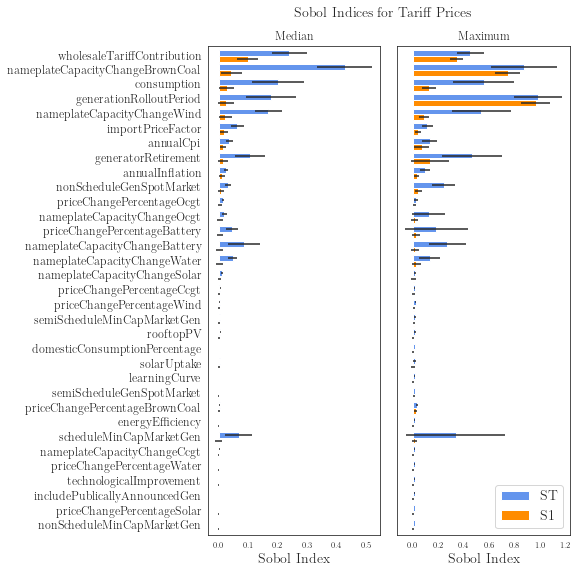

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


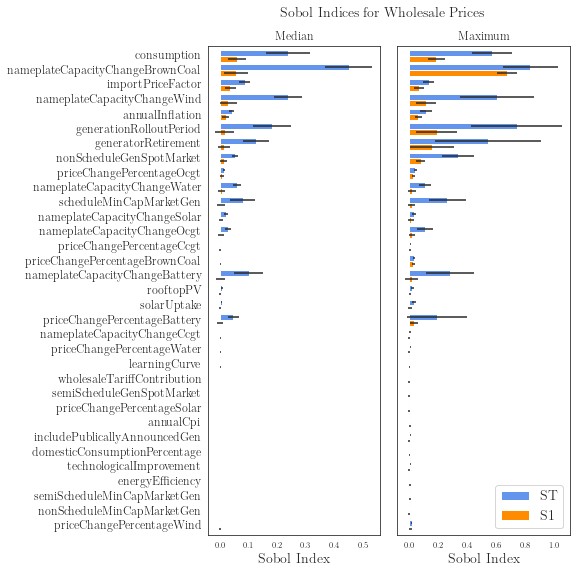

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


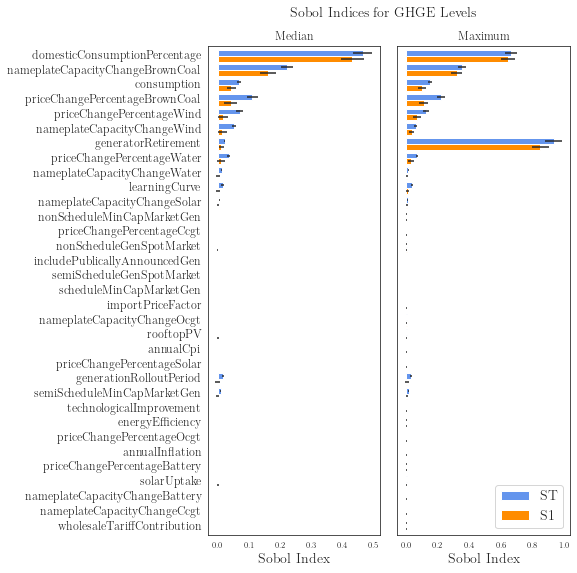

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


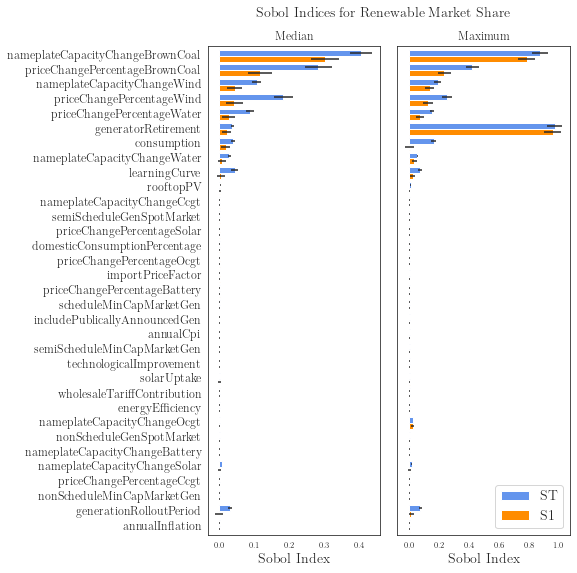

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


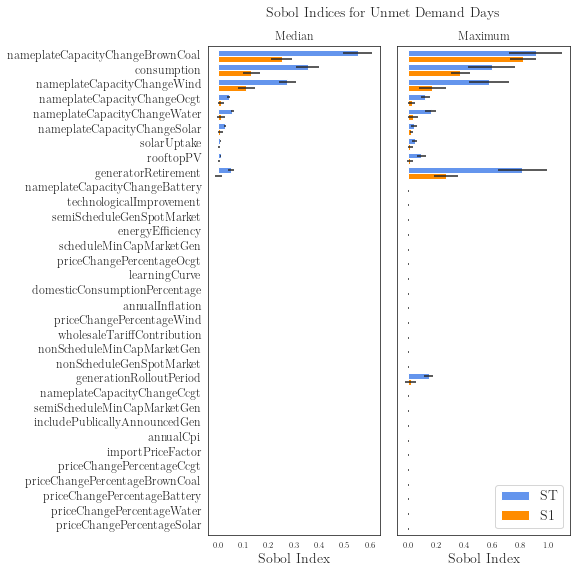

In [7]:
full_si = {}
plt.rcParams['text.usetex'] = True
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
# plt.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

names = zip(outcomes_to_show,['Tariff Prices', 'Wholesale Prices', 'GHGE Levels', 'Renewable Market Share', 'Unmet Demand Days'])
for ooi, name in tqdm(names):
    
#     Si_df = pd.concat({'S1_median': s1_median_ooi[ooi],'ST_median': st_median_ooi[ooi], 'S1_conf_median': s1_conf_median_ooi[ooi],'ST_conf_median': st_conf_median_ooi[ooi], 'S1_max': s1_max_val_ooi[ooi],'ST_max': st_max_val_ooi[ooi],'S1_conf_max': s1_conf_max_val_ooi[ooi],'ST_conf_max': st_conf_max_val_ooi[ooi]}, axis=1)
#     Si_df = Si_df.abs()
    
#     Si_df.sort_values(by=['S1_median'], ascending=True, inplace=True)    
    
    
#     full_si[ooi] = Si_df
    
    
    if includePlots:
        plot_scores_2(m_df[ooi], name)
        plt.show()


In [25]:
# import pickle
# with open("Mine.pickle", 'wb') as file:
#     pickle.dump(full_si, file)

In [11]:

    
from collections import defaultdict
un_vals = defaultdict(int)
for i in m_df.values():
    for j,k in i['S1_median'].iteritems():
        un_vals[j] = max(un_vals[j], k)

best = sorted(list(un_vals.items()), key = lambda a: -a[1])

In [15]:
print(pd.DataFrame([i[0] for i in best]).to_latex())

\begin{tabular}{ll}
\toprule
{} &                                 0 \\
\midrule
0  &     domesticConsumptionPercentage \\
1  &  nameplateCapacityChangeBrownCoal \\
2  &                       consumption \\
3  &    priceChangePercentageBrownCoal \\
4  &       nameplateCapacityChangeWind \\
5  &       wholesaleTariffContribution \\
6  &         priceChangePercentageWind \\
7  &                 importPriceFactor \\
8  &        priceChangePercentageWater \\
9  &           generationRolloutPeriod \\
10 &               generatorRetirement \\
11 &                   annualInflation \\
12 &                         annualCpi \\
13 &          nonScheduleGenSpotMarket \\
14 &       nameplateCapacityChangeOcgt \\
15 &      nameplateCapacityChangeWater \\
16 &      nameplateCapacityChangeSolar \\
17 &                     learningCurve \\
18 &         priceChangePercentageOcgt \\
19 &      priceChangePercentageBattery \\
20 &           scheduleMinCapMarketGen \\
21 &                       solarUptake

In [148]:
all_uncs = pd.DataFrame(best)
all_uncs.columns = ['Uncertainty', 'Median S1 (Max)']
# all_uncs.index = a

In [150]:
print(all_uncs.to_latex())

\begin{tabular}{llr}
\toprule
{} &                       Uncertainty &  Median S1 (Max) \\
\midrule
0  &     domesticConsumptionPercentage &         0.431463 \\
1  &  nameplateCapacityChangeBrownCoal &         0.300210 \\
2  &                       consumption &         0.131273 \\
3  &    priceChangePercentageBrownCoal &         0.116118 \\
4  &       nameplateCapacityChangeWind &         0.110605 \\
5  &       wholesaleTariffContribution &         0.097860 \\
6  &         priceChangePercentageWind &         0.042516 \\
7  &                 importPriceFactor &         0.036200 \\
8  &        priceChangePercentageWater &         0.025920 \\
9  &           generationRolloutPeriod &         0.024005 \\
10 &               generatorRetirement &         0.021296 \\
11 &                   annualInflation &         0.019931 \\
12 &                         annualCpi &         0.015158 \\
13 &          nonScheduleGenSpotMarket &         0.012657 \\
14 &       nameplateCapacityChangeOcgt &      

In [ ]:
import seaborn as sns
# sns.set_theme()
# sns.set_style("whitegrid")

writer = pd.ExcelWriter('{}/SOBOL_{}.xlsx'.format(r'/home/XXX/Desktop', '_median_sensitivity_Indices'))

#f = plt.figure(figsize=(20,30)) 
for ooi in outcomes_to_show:
    
    Si_df_median = pd.concat({'S1': s1_median_ooi[ooi],'ST': st_median_ooi[ooi], 'S2': s2_median_ooi[ooi],'S1_conf': s1_conf_median_ooi[ooi],'ST_conf': st_conf_median_ooi[ooi], 'S2_conf': s2_conf_median_ooi[ooi]}, axis=1)
    Si_df_max = pd.concat({'S1': s1_max_val_ooi[ooi],'ST': st_max_val_ooi[ooi], 'S2': s2_max_val_ooi[ooi],'S1_conf': s1_conf_max_val_ooi[ooi],'ST_conf': st_conf_max_val_ooi[ooi], 'S2_conf': s2_conf_max_val_ooi[ooi]}, axis=1)
    sortMedian = Si_df_median.sort_values
    
    if includePlots:
        fig, ax = plt.subplots(2, sharex=True)
        fig.set_size_inches(20,15)
        fig.suptitle(ooi, fontsize=28)

        ax[0].set_title("Median", fontsize=20)
        ax[1].set_title("Maximum", fontsize=20)

        plt.xticks (fontsize = 18)
        plt.yticks (fontsize = 18)
        ax[0].tick_params(labelsize=18)

        indices_median = Si_df_median[['S1','ST']]
        err_median = Si_df_median[['S1_conf','ST_conf']]

        indices_max = Si_df_max[['S1','ST']]
        err_max = Si_df_max[['S1_conf','ST_conf']]

        indices_median.plot.bar(yerr=err_median.values.T,ax=ax[0], width=0.8)
        indices_max.plot.bar(yerr=err_max.values.T,ax=ax[1], width = 0.8)
        for p, text_s1, text_st in zip(ax[1].patches, s1_max_val_year_ooi[ooi], st_max_val_year_ooi[ooi]):
            if p.get_height() >= 0.1: #to include all years use =! 0
                ax[1].annotate(str(text_s1), (p.get_x() - 0.03, p.get_height() + .035) ,fontsize=14, rotation='vertical')
                ax[1].annotate(str(text_st), (p.get_x() + 0.5, p.get_height() + .05) ,fontsize=14,  rotation='vertical')
                               
        ax[0].legend(['S1','ST'], fontsize=14)
        ax[1].legend(['S1','ST'], fontsize=14)
    
        #break
        
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_barplot_s1_st_%s'%(ooi)),dpi=300, bbox_inches='tight')
        
    print(ooi)
    
    if ooi == 'secondaryMaxUnmetDemandMwhPerHour':
        ooi = 'secondMaxUnmetMwhPerHour'
        
    Si_df_median.to_excel(writer, sheet_name=ooi)

    
    

writer.save()

### S2, S1, and ST plots

In [ ]:
# #%matplotlib inline
# sns.set_style('whitegrid')
# if includePlots:
#     for ooi in outcomes_to_show:

#         #Maximum
#         Si_df_max = {'S1': s1_max_val_ooi[ooi].to_numpy(),'S2': s2_max_val_ooi[ooi].to_numpy(),
#                      'ST': st_max_val_ooi[ooi].to_numpy(),'S1_conf': s1_conf_max_val_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_max_val_ooi[ooi].to_numpy(),'ST_conf': st_conf_max_val_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_max, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi)   

#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_max_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         #Median
#         Si_df_avg = {'S1': s1_median_ooi[ooi].to_numpy(),'S2': s2_median_ooi[ooi].to_numpy(),
#                      'ST': st_median_ooi[ooi].to_numpy(),'S1_conf': s1_conf_median_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_median_ooi[ooi].to_numpy(),'ST_conf': st_conf_median_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_median, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi, fontsize=16)   



#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_median_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         print(ooi)
     

## S2

In [ ]:
sns.set_style("white")
includePlots=True
#change colorpalette: https://seaborn.pydata.org/generated/seaborn.diverging_palette.html and https://colorbrewer2.org/#type=diverging&scheme=PiYG&n=3

if includePlots:
    for ooi in outcomes_to_show:
        corr = s2_median_ooi[ooi]
        corr = corr.round(3)

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        #cmap = sns.diverging_palette(247,160, as_cmap=True, center = "light")
        #cmap = sns.color_palette("coolwarm", as_cmap=True)
        cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light")
        # Draw the heatmap
        sns.heatmap(corr.T, cmap=cmap, vmin=corr.min(axis=1).min(),vmax=corr.max(axis=1).max(), center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        f.suptitle(ooi, fontsize=18)
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_s2_median_%s'%(ooi)),dpi=300, bbox_inches='tight')
        #break

        